In [ ]:
#| include: false
! [ -e /content ] && pip install -Uqq gingado nbdev # install or upgrade gingado on colab

In [ ]:
#| include: false
#| echo: false

# Code below included to ensure compatibility with scikit-learn v1.1.x
from sklearn import set_config
set_config(display='text')

This notebook showcases one possible use of `gingado` by estimating economic growth across countries, using the dataset studied by @BARRO19941. You can run this notebook interactively, by clicking on the appropriate link above.

This dataset has been widely studied in economics. @belloni2011inference and @giannone2021illusion are two studies of this dataset that are most related to machine learning.

This notebook will use `gingado` to compare quickly setup a well-performing machine learning model and use its results as evidence to support the conditional convergence hypothesis; compare different classes of models (and their combination in a single model), and use and document the best performing alternative. 

Because the notebook is for pedagogical purposes only, please bear in mind some aspects of the machine learning workflow (such as carefully thinking about the cross-validation strategy) are glossed over in this notebook. Also, only the key academic references are cited; more references can be found in the papers mentioned in this example.

For a more thorough description of `gingado`, please refer to the package's [website](https://dkgaraujo.github.io/gingado) and to the academic [material](https://www.github.com/dkgaraujo/gingado_comms) about it.

## Setting the stage

We will import packages as the work progresses. This will help highlight the specific steps in the workflow that `gingado` can be helpful with.

In [ ]:
import pandas as pd

The data is available in the [online annex](https://onlinelibrary.wiley.com/doi/abs/10.3982/ECTA17842) to @giannone2021illusion. In that paper, this dataset corresponds to what the authors call "macro2". The original data, along with more information on the variables, can be found in [this NBER website](http://www2.nber.org/pub/barro.lee/). A very helpful codebook is found [in this repo](https://github.com/bizmaercq/Do-Poor-Countries-Grow-Faster-than-Rich-Countries/blob/master/data/Codebook.txt).

In [ ]:
from gingado.datasets import load_BarroLee_1994

X, y = load_BarroLee_1994()

The dataset contains explanatory variables representing per-capita growth between 1960 and 1985, for 90 countries.

In [ ]:
X.columns

Index(['Unnamed: 0', 'gdpsh465', 'bmp1l', 'freeop', 'freetar', 'h65', 'hm65',
       'hf65', 'p65', 'pm65', 'pf65', 's65', 'sm65', 'sf65', 'fert65',
       'mort65', 'lifee065', 'gpop1', 'fert1', 'mort1', 'invsh41', 'geetot1',
       'geerec1', 'gde1', 'govwb1', 'govsh41', 'gvxdxe41', 'high65', 'highm65',
       'highf65', 'highc65', 'highcm65', 'highcf65', 'human65', 'humanm65',
       'humanf65', 'hyr65', 'hyrm65', 'hyrf65', 'no65', 'nom65', 'nof65',
       'pinstab1', 'pop65', 'worker65', 'pop1565', 'pop6565', 'sec65',
       'secm65', 'secf65', 'secc65', 'seccm65', 'seccf65', 'syr65', 'syrm65',
       'syrf65', 'teapri65', 'teasec65', 'ex1', 'im1', 'xr65', 'tot1'],
      dtype='object')

In [ ]:
X.head().T

,0,1,2,3,4
Unnamed: 0,0.000000,1.000000,2.000000,3.000000,4.000000
gdpsh465,6.591674,6.829794,8.895082,7.565275,7.162397
bmp1l,0.283700,0.614100,0.000000,0.199700,0.174000
freeop,0.153491,0.313509,0.204244,0.248714,0.299252
freetar,0.043888,0.061827,0.009186,0.036270,0.037367
...,...,...,...,...,...
teasec65,17.300000,18.000000,20.700000,22.700000,17.600000
ex1,0.072900,0.094000,0.174100,0.126500,0.121100
im1,0.066700,0.143800,0.175000,0.149600,0.130800
xr65,0.348000,0.525000,1.082000,6.625000,2.500000


The outcome variable is represented here:

<AxesSubplot:title={'center':'GDP growth'}, ylabel='Frequency'>

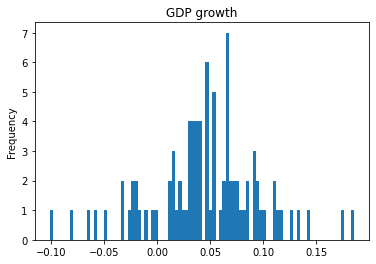

In [ ]:
y.plot.hist(bins=90, title='GDP growth')

## Establishing a benchmark model

Generally speaking, it is a good idea to establish a benchmark model at the first stages of development of the machine learning model. `gingado` offers a class of automatic benchmarks that can be used off-the-shelf depending on the task at hand: `RegressionBenchmark` and `ClassificationBenchmark`. It is also good to keep in mind that more advanced users can create their own benchmark on top of a base class provided by `gingado`: `ggdBenchmark`.

For this application, since we are interested in running a regression task, we will use `RegressionBenchmark`:

In [ ]:
from gingado.benchmark import RegressionBenchmark

What this object does is the following:

* it creates a random forest

* three different versions of the random forest are trained on the user data

* the version that performs better is chosen as the benchmark

* right after it is trained, the benchmark is documented using `gingado`'s `ModelCard` documenter.

The user can easily change the parameters above. For example, instead of a random forest the user might prefer a neural network as the benchmark. Or, in lieu of the default parameters provided by `gingado`, users might have their own idea of what could be a reasonable parameter space to search.

Random forests are chosen as the go-to benchmark algorithm because of their reasonably good performance in a wide variety of settings, the fact that they don't require much data transformation (ie, normalising the data to have zero mean and one standard deviation), and by virtue of their relatively transparency about the importance of each regressor.

The first step is to initialise the benchmark object. At this time, we pass some arguments about how we want it to behave. In this case, we set the verbosity level to produce output related to each alternative considered. Then we fit it to the data.

In [ ]:
#####
#####
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()
rfr.fit(X, y)

RandomForestRegressor()

In [ ]:
benchmark = RegressionBenchmark(verbose_grid=2)
benchmark.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=log2, n_estimators=100; total time=   0.1s
[CV] END ................max_features=log2, n_est

RegressionBenchmark(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None),
                    verbose_grid=2)

As we can see above, with a few lines we have trained a random forest on the dataset. In this case, the benchmark was the better of six versions of the random forest, according to the default hyperparameters: 100 and 250 estimators were alternated with models for which the maximum number of regressors analysed by individual trees changesd fom the maximum, a square root and a log of the number of regressors. They were each trained using a 5-fold cross-validation. 

Let's see which one was the best performing in this case, and hence our benchmark model:

In [ ]:
pd.DataFrame(benchmark.benchmark.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.127842,0.267661,0.106398,0.268515,0.163344,0.43746
std_fit_time,0.011492,0.015168,0.004224,0.01286,0.009028,0.006711
mean_score_time,0.007325,0.013783,0.005755,0.014542,0.005953,0.015245
std_score_time,0.001457,0.000516,0.000381,0.001177,0.000455,0.001707
param_max_features,sqrt,sqrt,log2,log2,None,None
param_n_estimators,100,250,100,250,100,250
params,"{'max_features': 'sqrt', 'n_estimators': 100}","{'max_features': 'sqrt', 'n_estimators': 250}","{'max_features': 'log2', 'n_estimators': 100}","{'max_features': 'log2', 'n_estimators': 250}","{'max_features': None, 'n_estimators': 100}","{'max_features': None, 'n_estimators': 250}"
split0_test_score,-0.16933,-0.092086,-0.122926,-0.211516,-0.108522,-0.160882
split1_test_score,-0.295742,-0.277869,-0.334904,-0.267957,-0.353692,-0.329935
split2_test_score,0.204602,0.085291,-0.037415,0.082589,0.404614,0.411464


The values above are calculated with $R^2$, the default scoring function for a random forest from the `scikit-learn` package. Suppose that instead we would like a benchmark model that is optimised on the maximum error, ie a benchmark that minimises the worst deviation from prediction to ground truth for all the sample. These are the steps that we would take. Note that a more complete list of ready-made scoring parameters and how to create your own function can be found [here](https://scikit-learn.org/stable/modules/model_evaluation.html#).

In [ ]:
benchmark_lower_worsterror = RegressionBenchmark(scoring='max_error', verbose_grid=2)
benchmark_lower_worsterror.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=log2, n_estimators=100; total time=   0.1s
[CV] END ................max_features=log2, n_est

RegressionBenchmark(cv=StratifiedShuffleSplit(n_splits=10, random_state=None, test_size=None,
            train_size=None),
                    scoring='max_error', verbose_grid=2)

In [ ]:
pd.DataFrame(benchmark_lower_worsterror.benchmark.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.125901,0.284121,0.116043,0.25507,0.16534,0.446526
std_fit_time,0.010974,0.013291,0.003123,0.002374,0.006095,0.029097
mean_score_time,0.006425,0.013692,0.006476,0.013916,0.005643,0.015142
std_score_time,0.000569,0.000061,0.000596,0.00071,0.000369,0.001178
param_max_features,sqrt,sqrt,log2,log2,None,None
param_n_estimators,100,250,100,250,100,250
params,"{'max_features': 'sqrt', 'n_estimators': 100}","{'max_features': 'sqrt', 'n_estimators': 250}","{'max_features': 'log2', 'n_estimators': 100}","{'max_features': 'log2', 'n_estimators': 250}","{'max_features': None, 'n_estimators': 100}","{'max_features': None, 'n_estimators': 250}"
split0_test_score,-0.091383,-0.09865,-0.089205,-0.089668,-0.099687,-0.100254
split1_test_score,-0.13291,-0.131386,-0.126901,-0.131514,-0.168115,-0.166914
split2_test_score,-0.105365,-0.103247,-0.107508,-0.110758,-0.087416,-0.089252


Now we even have two benchmark models.

We could further tweak and adjust them, but one of the ideas behind having a benchmark is that it is simple and easy to set up. 

Let's retain only the first benchmark, for simplicity, and now look at the predictions, comparing them to the original growth values.

/Users/douglasaraujo/Coding/.venv_gingado/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


<AxesSubplot:title={'center':'Actual and predicted outcome'}, xlabel='actual GDP growth', ylabel='predicted GDP growth'>

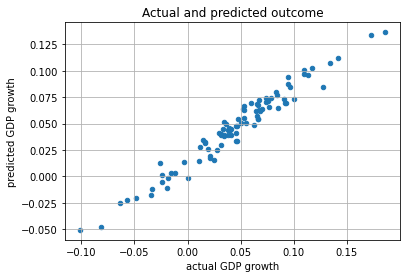

In [ ]:
y_pred = benchmark.predict(X)

pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(
        x='y', y='y_pred',
         grid=True, 
         title='Actual and predicted outcome',
         xlabel='actual GDP growth',
         ylabel='predicted GDP growth')

And now a histogram of the benchmark's errors:

<AxesSubplot:title={'center':'Residual'}, ylabel='Frequency'>

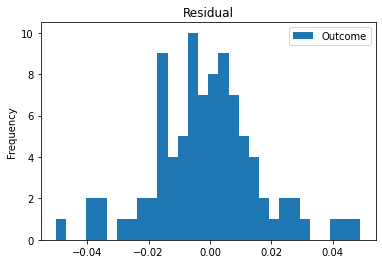

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30, title='Residual')

Since the benchmark is a random forest model, we can see what are the most important regressors, measured as the average reduction in impurity across the trees in the random forest that actually use that particular regressor. They are scaled so that the sum for all features is one. Higher importance amounts indicate that that particular regressor is a more important contributor to the final prediction.

<AxesSubplot:title={'center':'Regressor importance'}>

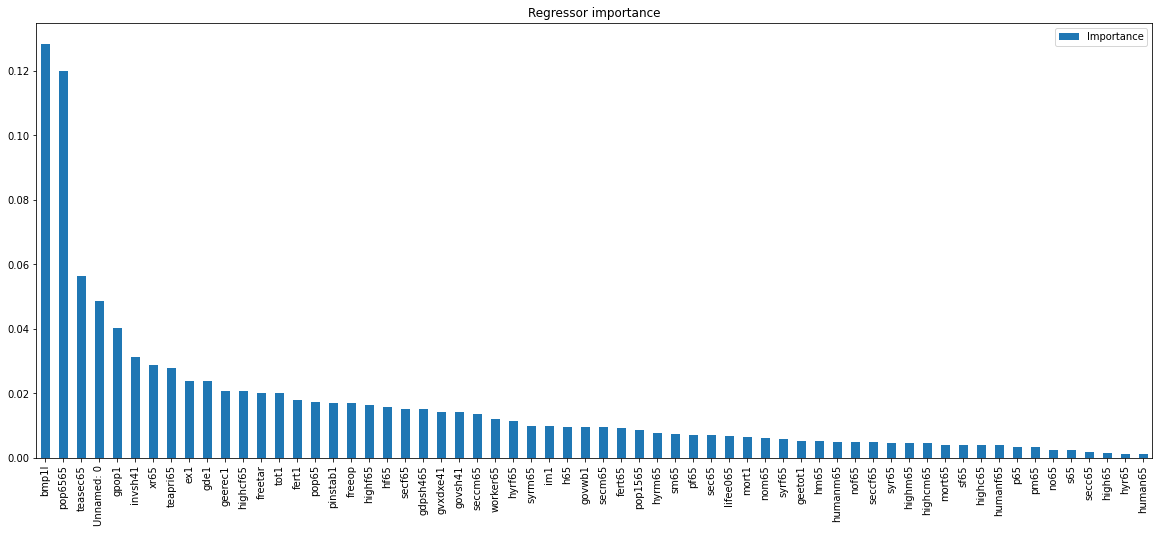

In [ ]:
regressor_importance = pd.DataFrame(
    benchmark.benchmark.best_estimator_.feature_importances_, 
    index=X.columns, 
    columns=["Importance"]
    )

regressor_importance.sort_values(by="Importance", ascending=False) \
    .plot.bar(figsize=(20, 8), title='Regressor importance')

From the graph above, we can see that the regressor `bmp1l` (black-market premium on foreign exchange) predominates. Interestingly, @belloni2011inference using squared-root lasso also find this regressor to be important.

## Testing the conditional converge hypothesis

Now we can leverage our automatic benchmark model to test the conditional converge hypothesis - ie, the preposition that countries with lower starting GDP tend to grow faster than other *comparable* countries. In other words, this hypothesis predicts that when GDP growth is regressed on the level of past GDP and on an adequate set of covariates $X$, the coefficient on past GDP levels are negative.

Since we have the results for the importance of each regressor in separating countries by their growth result, we can compare the estimated coefficient for GDP levels in regressions that include different regressors in the vector $X$. To maintain this example a simple exercise, the following three models are estimated:

* $X$ contains the five most important regressors, as estimated by the benchmark model (see the graph above)
* $X$ contains the five *least* important regressors, from the same estimation as above
* $X$ is the empty set - in other words, this is a simple equation on GDP growth on GDP levels

A result that would be consistent with the *conditionality* of the conditional convergence hypothesis is the first equation resulting in a negative coefficient for starting GDP, while the following two equations may not necessarily be successful in identifying a negative coefficient. This is because the least important regressors are not likely to have sufficient predictive power to separate countries into comparable groups.

The five more and less important regressors are:

In [ ]:
top_five = regressor_importance.sort_values(by="Importance", ascending=False).head(5)
bottom_five = regressor_importance.sort_values(by="Importance", ascending=True).head(5)

top_five, bottom_five

(            Importance
 bmp1l         0.128438
 pop6565       0.120012
 teasec65      0.056266
 Unnamed: 0    0.048724
 gpop1         0.040157,
          Importance
 human65    0.001123
 hyr65      0.001158
 high65     0.001531
 secc65     0.001928
 s65        0.002282)

In [ ]:
import statsmodels.api as sm

In [ ]:
gdp_level = 'gdpsh465'

In [ ]:
X_topfive = X[[gdp_level] + list(top_five.index)]
X_topfive = sm.add_constant(X_topfive)
X_topfive.head()

,const,gdpsh465,bmp1l,pop6565,teasec65,Unnamed: 0,gpop1
0,1.0,6.591674,0.2837,0.027591,17.3,0,0.0203
1,1.0,6.829794,0.6141,0.035637,18.0,1,0.0185
2,1.0,8.895082,0.0000,0.076685,20.7,2,0.0188
3,1.0,7.565275,0.1997,0.031039,22.7,3,0.0345
4,1.0,7.162397,0.1740,0.026281,17.6,4,0.0310


In [ ]:
X_bottomfive = X[[gdp_level] + list(bottom_five.index)]
X_bottomfive = sm.add_constant(X_bottomfive)
X_bottomfive.head()

,const,gdpsh465,human65,hyr65,high65,secc65,s65
0,1.0,6.591674,0.301,0.004,0.12,0.13,0.04
1,1.0,6.829794,0.706,0.027,0.70,1.36,0.16
2,1.0,8.895082,8.317,0.424,16.67,15.68,0.56
3,1.0,7.565275,3.833,0.104,3.10,2.76,0.24
4,1.0,7.162397,1.900,0.022,0.67,2.17,0.17


In [ ]:
X_onlyGDPlevel = sm.add_constant(X[gdp_level])
X_onlyGDPlevel.head()

,const,gdpsh465
0,1.0,6.591674
1,1.0,6.829794
2,1.0,8.895082
3,1.0,7.565275
4,1.0,7.162397


In [ ]:
models = dict(
    topfive = sm.OLS(y, X_topfive).fit(),
    bottomfive = sm.OLS(y, X_bottomfive).fit(),
    onlyGDPlevel = sm.OLS(y, X_onlyGDPlevel).fit()
)

In [ ]:
coefs = pd.DataFrame({name: model.conf_int().loc[gdp_level] for name, model in models.items()})
coefs.loc[0.5] = [model.params[gdp_level] for _, model in models.items()]
coefs = coefs.sort_index().reset_index(drop=True)
coefs.index = ['[0.025', 'coef on GDP levels', '0.975]']
coefs

,topfive,bottomfive,onlyGDPlevel
[0.025,-0.033143,-0.037257,-0.010810
coef on GDP levels,-0.016378,-0.014432,0.001317
0.975],0.000387,0.008394,0.013444


The equation using the top five regressors in explanatory power yielded a coefficient that is statistically speaking negative under the usual confidence interval levels. In contrast, the regression using the bottom five regressors failed to maintain that level of statistical significance (although the coefficient point estimate was still negative). And finally the regression on GDP level solely resulted, as in the past literature, on a point estimate that is also statistically not different than zero.

These results above offer a different way to add evidence to the conditional convergence hypothesis. In particular, with the help of `gingado`'s `RegressionBenchmark` model, it is possible to identify which covariates can meaningfully serve as covariates in a growth equation from those that cannot. This is important because if the covariate selection for some reason included only variables with little explanatory power instead of the most relevant ones, an economist might erroneously reach a different conclusion.

## Model documentation

Importantly for model documentation, the benchmark already has some baseline documentation set up. If the user wishes, they can use that as a basis to document their model. Note that the output is in a raw format that is suitable for machine reading and writing. Intermediary and advanced users may wish to use that format to construct personalised forms, documents, etc.

In [ ]:
benchmark.model_documentation.show_json()

{'model_details': {'developer': 'Person or organisation developing the model',
  'datetime': '2022-09-24 00:46:53 ',
  'version': 'Model version',
  'type': 'Model type',
  'info': {'_estimator_type': 'regressor',
   'best_estimator_': RandomForestRegressor(max_features=None, oob_score=True),
   'best_index_': 4,
   'best_params_': {'max_features': None, 'n_estimators': 100},
   'best_score_': -0.08054342152726568,
   'cv_results_': {'mean_fit_time': array([0.12784224, 0.26766114, 0.10639763, 0.26851478, 0.16334381,
           0.43746042]),
    'std_fit_time': array([0.01149181, 0.0151677 , 0.00422391, 0.01286013, 0.00902753,
           0.00671144]),
    'mean_score_time': array([0.00732503, 0.01378322, 0.00575457, 0.01454234, 0.00595331,
           0.01524515]),
    'std_score_time': array([0.00145713, 0.00051617, 0.00038052, 0.00117699, 0.00045451,
           0.00170701]),
    'param_max_features': masked_array(data=['sqrt', 'sqrt', 'log2', 'log2', None, None],
                 mask=

Since there is some information in the model documentation that was automatically added, we might want to concentrate on the fields in the model card that are yet to be answered. Actually, this is the purpose of `gingado`'s automatic documentation: to afford users more time so they can invest, if they want, on model documentation.

In [ ]:
benchmark.model_documentation.open_questions()

['model_details__developer',
 'model_details__version',
 'model_details__type',
 'model_details__paper',
 'model_details__citation',
 'model_details__license',
 'model_details__contact',
 'intended_use__primary_uses',
 'intended_use__primary_users',
 'intended_use__out_of_scope',
 'factors__relevant',
 'factors__evaluation',
 'metrics__performance_measures',
 'metrics__thresholds',
 'metrics__variation_approaches',
 'evaluation_data__datasets',
 'evaluation_data__motivation',
 'evaluation_data__preprocessing',
 'training_data__training_data',
 'quant_analyses__unitary',
 'quant_analyses__intersectional',
 'ethical_considerations__sensitive_data',
 'ethical_considerations__human_life',
 'ethical_considerations__mitigations',
 'ethical_considerations__risks_and_harms',
 'ethical_considerations__use_cases',
 'ethical_considerations__additional_information',
 'caveats_recommendations__caveats',
 'caveats_recommendations__recommendations']

Let's fill some information:

In [ ]:
benchmark.model_documentation.fill_info({
    'intended_use': {
        'primary_uses': 'This model is trained for pedagogical uses only.',
        'primary_users': 'Everyone is welcome to follow the description showing the development of this benchmark.'
    }
})

Note the format, based on a Python dictionary. In particular, the `open_questions` method results include keys divided by double underscores. As seen above, these should be interpreted as different levels of the documentation template, leading to a nested dictionary. 

Now when we confirm that the questions answered above are no longer "open questions":

In [ ]:
benchmark.model_documentation.open_questions()

['model_details__developer',
 'model_details__version',
 'model_details__type',
 'model_details__paper',
 'model_details__citation',
 'model_details__license',
 'model_details__contact',
 'intended_use__out_of_scope',
 'factors__relevant',
 'factors__evaluation',
 'metrics__performance_measures',
 'metrics__thresholds',
 'metrics__variation_approaches',
 'evaluation_data__datasets',
 'evaluation_data__motivation',
 'evaluation_data__preprocessing',
 'training_data__training_data',
 'quant_analyses__unitary',
 'quant_analyses__intersectional',
 'ethical_considerations__sensitive_data',
 'ethical_considerations__human_life',
 'ethical_considerations__mitigations',
 'ethical_considerations__risks_and_harms',
 'ethical_considerations__use_cases',
 'ethical_considerations__additional_information',
 'caveats_recommendations__caveats',
 'caveats_recommendations__recommendations']

If we want, at any time we can save the documentation to a local JSON file, as well as read another document.

## Trying out model alternatives

The benchmark model may be enough for some analyses, or maybe the user is interested in using the benchmark to explore the data and have an understanding of the importance of each regressor, to concentrate their work on data that can be meaningful for their purposes. But oftentimes a user will want to seek a machine learning model that performs as well as possible.

For users that want to manually create other models, `gingado` allows the possibility of comparing them with the benchmark. If the user model is better, it becomes the new benchmark!

For the following analyses, we will use K-fold as cross-validation, with 5 splits of the sample.

### First candidate: a gradient boosting tree

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.25],
    'max_depth': [3, 6, 9]
}

reg_gradbooster = GradientBoostingRegressor()

gradboosterg_grid = GridSearchCV(
    reg_gradbooster,
    param_grid,
    n_jobs=-1,
    verbose=2
).fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=3; total time=   0.1s
[CV] END ....................learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END ....................learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END ....................learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END ....................learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END ....................learning_rate=0.01, max_depth=6; total time=   0.2s
[CV] END .....................learning_rate=0.1, max_depth=3; total time=   0.1s
[CV] END .....................learning_rate=0.1, 

<AxesSubplot:xlabel='y', ylabel='y_pred'>

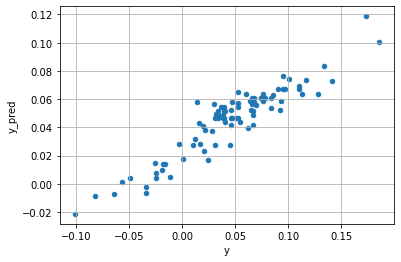

In [ ]:
y_pred = gradboosterg_grid.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

<AxesSubplot:ylabel='Frequency'>

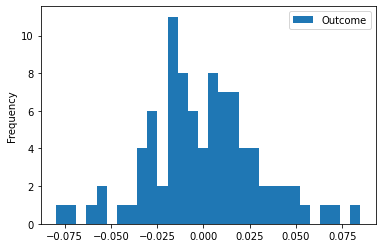

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

### Second candidate: lasso

In [ ]:
from sklearn.linear_model import Lasso

In [ ]:
param_grid = {
    'alpha': [0.5, 1, 1.25],
}

reg_lasso = Lasso(fit_intercept=True)

lasso_grid = GridSearchCV(
    reg_lasso,
    param_grid,
    n_jobs=-1,
    verbose=2
).fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END ............................................alpha=1; total time=   0.0s
[CV] END .........................................alpha=1.25; total time=   0.0s
[CV] END ........................................

<AxesSubplot:xlabel='y', ylabel='y_pred'>

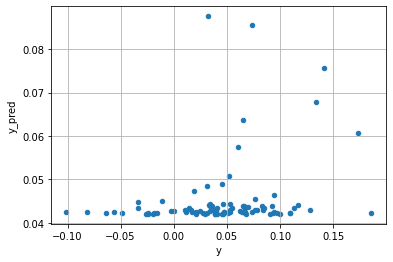

In [ ]:
y_pred = lasso_grid.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

<AxesSubplot:ylabel='Frequency'>

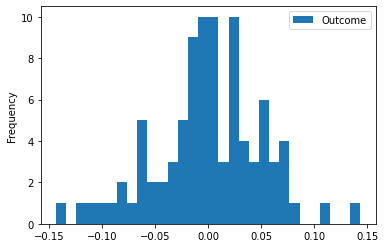

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

## Comparing the models with the benchmark

`gingado` allows users to compare different candidate models with the existing benchmark in a very simple way: using the `compare` method.

In [ ]:
candidates = [gradboosterg_grid, lasso_grid]
benchmark.compare(X, y, candidates)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.2s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=100; total time=   0.1s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=sqrt, n_estimators=250; total time=   0.3s
[CV] END ................max_features=log2, n_estimators=100; total ti

The output above clearly indicates that after evaluating the models - and their ensemble together with the existing benchmark - at least one of them was better than the current benchmark. Therefore, it will now be the new benchmark.

<AxesSubplot:xlabel='y', ylabel='y_pred'>

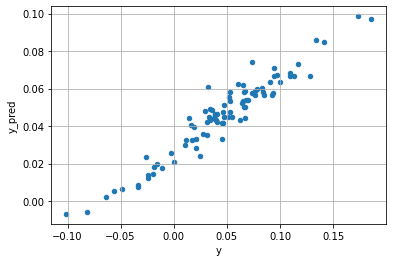

In [ ]:
y_pred = benchmark.predict(X)
pd.DataFrame({
    'y': y,
    'y_pred': y_pred
    }).plot.scatter(x='y', y='y_pred', grid=True)

<AxesSubplot:ylabel='Frequency'>

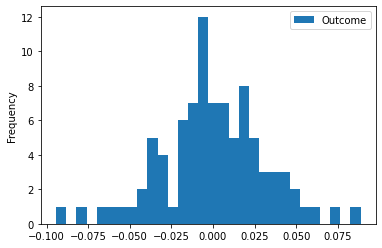

In [ ]:
pd.DataFrame(y - y_pred).plot.hist(bins=30)

## Model documentation

After this process, we can now see how the model documentation was updated automatically:

In [ ]:
benchmark.model_documentation.show_json()

{'model_details': {'developer': 'Person or organisation developing the model',
  'datetime': '2022-09-24 00:48:34 ',
  'version': 'Model version',
  'type': 'Model type',
  'info': {'_estimator_type': 'regressor',
   'best_estimator_': Pipeline(steps=[('candidate_estimator',
                    VotingRegressor(estimators=[('candidate_1',
                                                 GridSearchCV(estimator=RandomForestRegressor(oob_score=True),
                                                              param_grid={'max_features': ['sqrt',
                                                                                           'log2',
                                                                                           None],
                                                                          'n_estimators': [100,
                                                                                           250]},
                                                           

And as before, any remaining open questions can be viewed and answered using the same methods as above.

## References

::: {#refs}
:::

In [ ]:
#| echo: false
import nbdev; nbdev.nbdev_export()